In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve)

In [36]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/data/cleaned_motor_vehicle_collisions.csv')

In [37]:
display(df.head())
display(df.info())


,borough,crash_date,crash_time,day_of_week,month,is_weekend,hour,hour_category,season,pedestrian_involved,cyclist_involved,vehicle_type_code_1,vehicle_type_code_2,contributing_factor_vehicle_1,contributing_factor_vehicle_2,high_risk,KSI
0,Brooklyn,2023-11-01,01:29:00,2,11,0,1,Late_Night,Fall,0,0,MOPED,SEDAN,UNSPECIFIED,UNSPECIFIED,0,0
1,Queens,2022-09-22,16:16:00,3,9,0,16,Evening_Rush,Fall,0,0,SEDAN,E-SCOOTER,PASSING OR LANE USAGE IMPROPER,UNSPECIFIED,0,0
2,Queens,2023-01-12,21:00:00,3,1,0,21,Night,Winter,0,0,STATION WAGON/SPORT UTILITY VEHICLE,UNKNOWN,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0
3,Brooklyn,2022-07-12,17:50:00,1,7,0,17,Evening_Rush,Summer,0,0,SEDAN,UNKNOWN,OVERSIZED VEHICLE,UNSPECIFIED,0,0
4,Brooklyn,2022-04-24,16:45:00,6,4,1,16,Evening_Rush,Spring,0,0,STATION WAGON/SPORT UTILITY VEHICLE,STATION WAGON/SPORT UTILITY VEHICLE,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342418 entries, 0 to 342417
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   borough                        342418 non-null  object
 1   crash_date                     342418 non-null  object
 2   crash_time                     342418 non-null  object
 3   day_of_week                    342418 non-null  int64 
 4   month                          342418 non-null  int64 
 5   is_weekend                     342418 non-null  int64 
 6   hour                           342418 non-null  int64 
 7   hour_category                  342418 non-null  object
 8   season                         342418 non-null  object
 9   pedestrian_involved            342418 non-null  int64 
 10  cyclist_involved               342418 non-null  int64 
 11  vehicle_type_code_1            342418 non-null  object
 12  vehicle_type_code_2            342416 non-nu

None

In [38]:
df.isna().sum() 

borough                          0
crash_date                       0
crash_time                       0
day_of_week                      0
month                            0
is_weekend                       0
hour                             0
hour_category                    0
season                           0
pedestrian_involved              0
cyclist_involved                 0
vehicle_type_code_1              0
vehicle_type_code_2              2
contributing_factor_vehicle_1    0
contributing_factor_vehicle_2    0
high_risk                        0
KSI                              0
dtype: int64

In [39]:
# let's define features for modeling
numerical_features = ['hour', 'day_of_week', 'month']
categorical_features = ['borough', 'hour_category', 'season']

# Le't create a list for binary features
binary_features = ['is_weekend','pedestrian_involved', 'cyclist_involved', 'high_risk']

numerical_features.extend(binary_features)

all_features = numerical_features + categorical_features

In [40]:
# Now, let't define the target variable Y, along with features X
X = df[all_features].copy()
y = df['KSI'].copy() # target variable, binary classification

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # stratify to maintain class balance

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Train KSI rate: {y_train.mean()*100:.2f}%")
print(f"Test KSI rate: {y_test.mean()*100:.2f}%") 


Training set: 273,934 samples
Test set: 68,484 samples
Train KSI rate: 9.01%
Test KSI rate: 9.01%


In [42]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features)
    ]) #


### MODEL 2 - SIMPLE LOGISTIC REGRESSION (2-3 Features)

In [43]:
# Let's use only 2 ou 3 most important features to create a simple model
simple_features = ['hour_category', 'borough','pedestrian_involved']

X_train_simple_model = X_train[simple_features]
X_test_simple_model = X_test[simple_features]

# Determine which are categorical
simple_cat = [f for f in simple_features if f in categorical_features] #list comprehension to get categorical features
simple_num = [f for f in simple_features if f in numerical_features] #list comprehension to get categorical features

# Let's create a preprocessing pipeline for simple model
simple_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), simple_num),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         simple_cat)
    ]) 

In [44]:
# Now, let's create the simple model pipeline
simple_model = Pipeline([
    ('preprocessor', simple_preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')) #because of class imbalance
])


In [45]:
# Fit the model, predict and find the probability.
simple_model.fit(X_train_simple_model, y_train)
y_pred_simple_model = simple_model.predict(X_test_simple_model)
y_proba_simple_model = simple_model.predict_proba(X_test_simple_model)


In [46]:
# Evaluation 

simple_model_accuracy = accuracy_score(y_test, y_pred_simple_model)
simple_model_precision = precision_score(y_test, y_pred_simple_model)
simple_model_recall = recall_score(y_test, y_pred_simple_model)
simple_model_f1 = f1_score(y_test, y_pred_simple_model)

In [47]:
# use probability for the positive class (class 1) when computing ROC AUC
simple_model_auc = roc_auc_score(y_test, y_proba_simple_model[:, 1])

In [48]:
print("Baseline Model Performance:")
print(f"Simple Logistic regression model Accuracy: {simple_model_accuracy:.4f}")
print(f"Simple Logistic regression model Precision: {simple_model_precision:.4f}")
print(f"Simple Logistic regression model Recall: {simple_model_recall:.4f}")
print(f"Simple Logistic regression model F1 Score: {simple_model_f1:.4f}")
print(f"Simple Logistic regression model ROC-AUC: {simple_model_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_simple_model, zero_division=0))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_simple_model)
print(conf_matrix)

Baseline Model Performance:
Simple Logistic regression model Accuracy: 0.4827
Simple Logistic regression model Precision: 0.1040
Simple Logistic regression model Recall: 0.6225
Simple Logistic regression model F1 Score: 0.1783
Simple Logistic regression model ROC-AUC: 0.5630

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.47      0.62     62311
           1       0.10      0.62      0.18      6173

    accuracy                           0.48     68484
   macro avg       0.52      0.55      0.40     68484
weighted avg       0.85      0.48      0.58     68484

Confusion Matrix:
[[29215 33096]
 [ 2330  3843]]



--- Confusion Matrix for the simple model ---


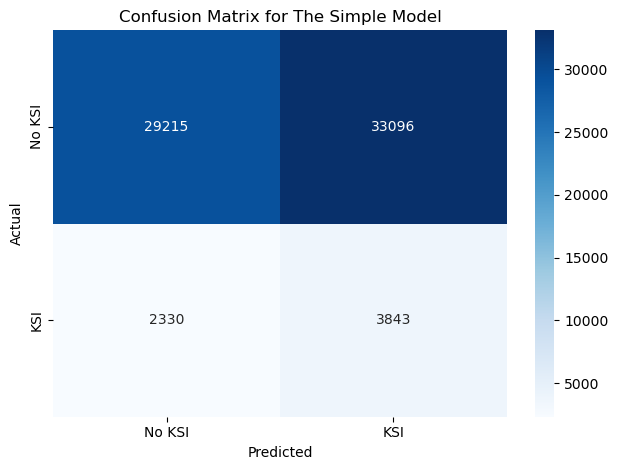

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Confusion Matrix for the simple model ---")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No KSI', 'KSI'], yticklabels=['No KSI', 'KSI'])
plt.title('Confusion Matrix for The Simple Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
#plt.savefig('/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/figures/simplemodel_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()



- Using only 3 features, the model can identify 62.3% of `KSI` cases.
- Precision of 0.104 means 10.4% of predicted KSI cases are correct.
- This is much better than the baseline (0% recall).

- Next step will be building a more complexe model and compared it to the first 2 to chose one for deployment. 


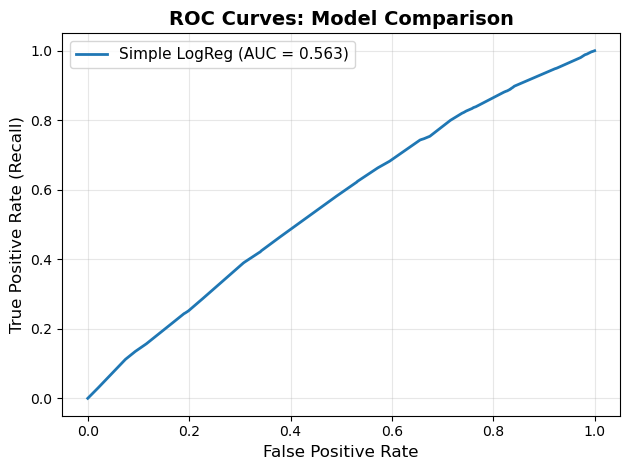

In [52]:
# compute ROC curve using probability for the positive class (class 1)
fpr_simple, tpr_simple, _ = roc_curve(y_test, y_proba_simple_model[:, 1])
plt.plot(fpr_simple, tpr_simple, label=f'Simple LogReg (AUC = {simple_model_auc:.3f})', linewidth=2)


plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

